In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [5]:
from helpers.convert_to_var_foo import convert_to_var

In [3]:
class Enet(nn.Module):
    def __init__(self, num_actions, input_dim,
                 num_hidden=2, hidden_size=512):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(nn.ReLU())
        for i in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, num_actions))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
        self.set_weights()


    def set_weights(self):
        state_dict = self.net.state_dict()
        keys = sorted(state_dict.keys())
        state_dict[keys[-2]] = torch.zeros_like(state_dict[keys[-2]])
        state_dict[keys[-1]] = torch.zeros_like(state_dict[keys[-1]])
        self.net.load_state_dict(state_dict)


    def forward(self, x):
        out = self.net(x)
        return out

In [45]:
alpha = 0.2
gamma_E = 0.9

def go_tree_cycle(k, e_lr=1e-5):
    e_model = Enet(num_actions=k+1, input_dim=50)

    optimizer = torch.optim.Adam(e_model.parameters(), lr=e_lr)
    MSEloss = nn.MSELoss()
    
    pseudo_counts = []
    for step in range(50):
        for i in range(1,k+1):
            start_state = convert_to_var(np.concatenate([np.ones(25), np.zeros(25)]))
            s0_state = convert_to_var(np.ones(50))
            
            loss = MSEloss(e_model.forward(start_state)[0],
                           gamma_E * e_model.forward(s0_state)[i].detach() )
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss = MSEloss(e_model.forward(s0_state)[i],
                           convert_to_var(np.zeros(1)))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        e_value = e_model.forward(start_state).data.numpy()[0]
        #print(e_value)
        pseudo_counts.append(np.log(e_value) / np.log(1-e_lr))
    return pseudo_counts

In [46]:
%%time
k_range = [10, 20, 30]

results_3 = []
for k in k_range:
    print(k)
    pseudo_counts = go_tree_cycle(k, e_lr=1e-3)
    results_3.append(pseudo_counts)


results_4 = []
for k in k_range:
    print(k)
    pseudo_counts = go_tree_cycle(k, e_lr=1e-4)
    results_4.append(pseudo_counts)
    
results_5 = []
for k in k_range:
    print(k)
    pseudo_counts = go_tree_cycle(k, e_lr=1e-5)
    results_5.append(pseudo_counts)

10
20
30
10
20
30
10
20
30
CPU times: user 14min 38s, sys: 2.12 s, total: 14min 40s
Wall time: 7min 58s


Text(0.5,1,'lr=1e-05')

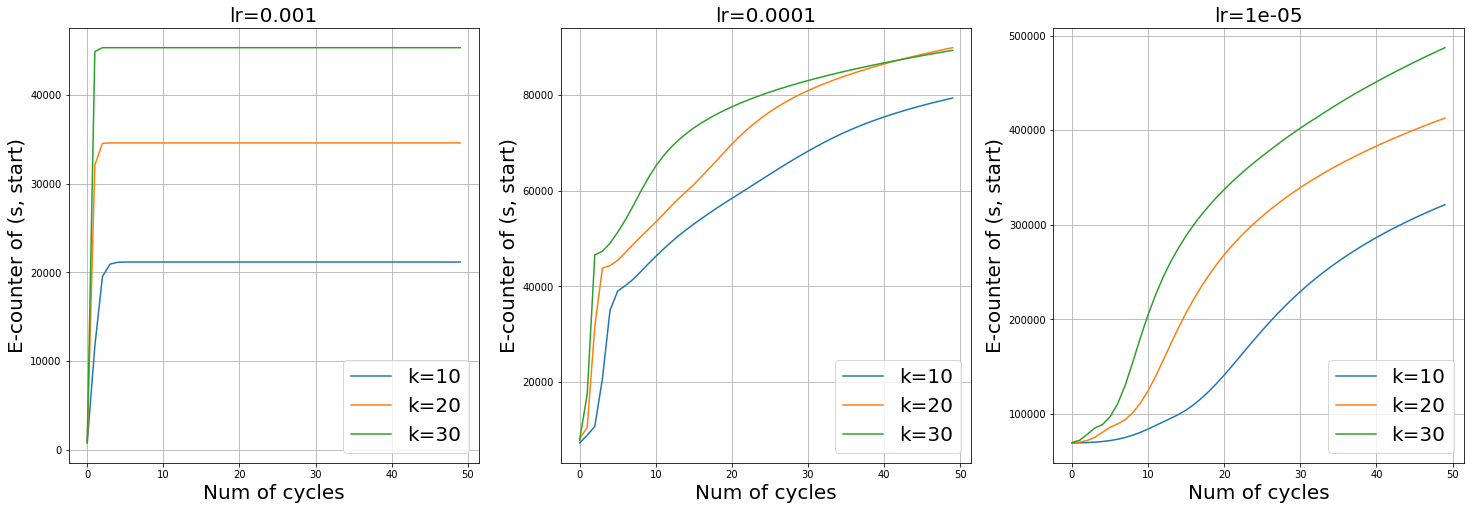

In [58]:
plt.figure(figsize=(25, 8))

fontsize=20

plt.subplot(1, 3, 1)
for i in range(len(k_range)):
    plt.plot(results_3[i], label="k={}".format(k_range[i]))
plt.grid()
plt.xlabel('Num of cycles', fontsize=fontsize)
plt.ylabel('E-counter of (s, start)', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)
plt.title('lr={}'.format(1e-3), fontsize=fontsize)


plt.subplot(1, 3, 2)
for i in range(len(k_range)):
    plt.plot(results_4[i], label="k={}".format(k_range[i]))
plt.grid()
plt.xlabel('Num of cycles', fontsize=fontsize)
plt.ylabel('E-counter of (s, start)', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)
plt.title('lr={}'.format(1e-4), fontsize=fontsize)


plt.subplot(1, 3, 3)
for i in range(len(k_range)):
    plt.plot(results_5[i], label="k={}".format(k_range[i]))
plt.grid()
plt.xlabel('Num of cycles', fontsize=fontsize)
plt.ylabel('E-counter of (s, start)', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)
plt.title('lr={}'.format(1e-5), fontsize=fontsize)

